
# CEU Slim simulations



Load global analysis variables:

In [1]:
%run standard.py

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
# from ChromosomeWindows import window
# import genominterv

In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("ticks")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

Ignore warnings:

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Load meta data

Easy loading of meta data in a consistent manner across code

In [8]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# Plot distributions of pi in 200kb windows as in Figure 1 of paper

In [9]:
import glob

df_list = []
hdf_files = glob.glob('../steps/slim/simulations/standard/87/recmap/*/X/nosweep/0/0/*0_0_0_twice.hdf')
for hdf_file in hdf_files:
    pw_dist = (pd.read_hdf(hdf_file)
                    .loc[lambda df: df.indiv_1 < df.indiv_2]
                    .sort_values(['indiv_1', 'indiv_2', 'start', 'end'])
                    )
    pw_dist['bin'] = pw_dist.start // 200000
    df = pw_dist.groupby(['indiv_1', 'indiv_2', 'bin']).dist.mean().to_frame()
    df_list.append(df)
sim_87_df = pd.concat(df_list)

df_list = []
hdf_files = glob.glob('../steps/slim/simulations/standard/68/recmap/*/X/nosweep/0/0/*0_0_0_twice.hdf')
for hdf_file in hdf_files:
    pw_dist = (pd.read_hdf(hdf_file)
                    .loc[lambda df: df.indiv_1 < df.indiv_2]
                    .sort_values(['indiv_1', 'indiv_2', 'start', 'end'])
                    )
    pw_dist['bin'] = pw_dist.start // 200000
    df = pw_dist.groupby(['indiv_1', 'indiv_2', 'bin']).dist.mean().to_frame()
    df_list.append(df)
sim_68_df = pd.concat(df_list)

In [10]:
pw_dist = (pd.read_hdf('../steps/1000genomes/male_dist_admix_masked_stores/X/CEU/male_dist_data_chrX_100kb_CEU.hdf')
                    .sort_values(['indiv_1', 'indiv_2', 'start', 'end'])
                    )
pw_dist['bin'] = pw_dist.start // 200000
ceu_df = pw_dist.groupby(['indiv_1', 'indiv_2', 'bin']).dist.mean().to_frame()

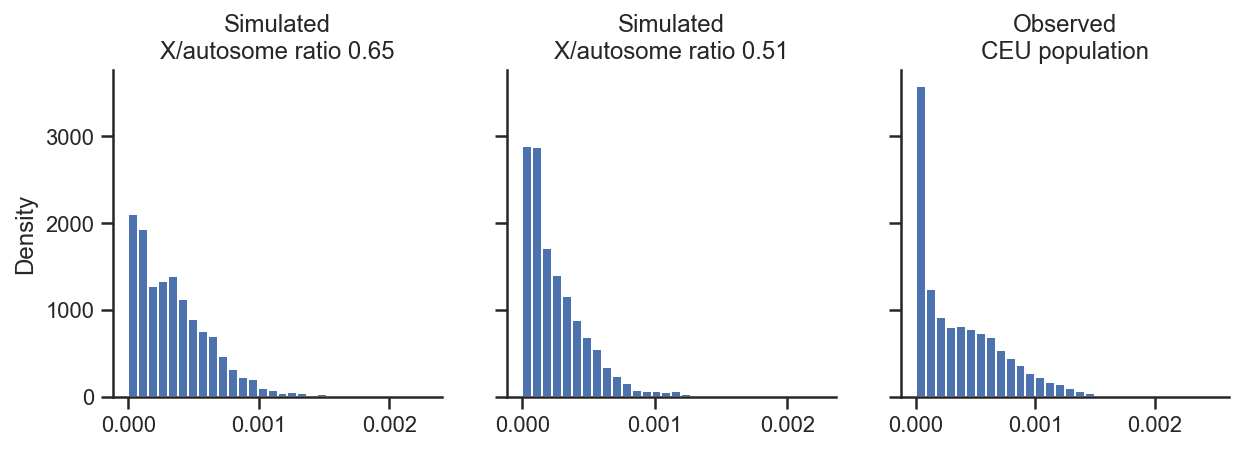

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10,3), sharey=True)
axes[0].hist(sim_87_df.loc[sim_87_df.dist < 0.0025, 'dist'], bins=30, density=True) ;
axes[0].set_title('Simulated\nX/autosome ratio 0.65')
axes[0].set_ylabel('Density')
axes[1].hist(sim_68_df.loc[sim_68_df.dist < 0.0025, 'dist'], bins=30, density=True) ;
axes[1].set_title('Simulated\nX/autosome ratio 0.51')
axes[2].hist(ceu_df.loc[ceu_df.dist < 0.0025, 'dist'], bins=30, density=True) ;
axes[2].set_title('Observed\nCEU population');
sns.despine()
#plt.xlim(right=0.0025)

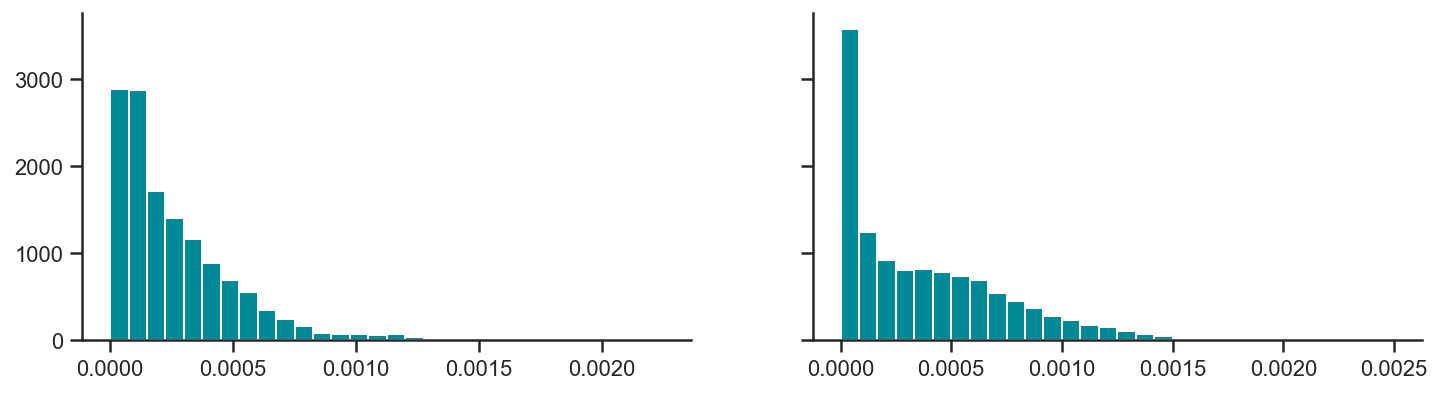

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,3), sharey=True)
axes[0].hist(sim_68_df.loc[sim_68_df.dist < 0.0025, 'dist'], bins=30, density=True, color='#008A97') ;
# axes[0].set_title('Simulated\nX/autosome ratio 0.51')
axes[1].hist(ceu_df.loc[ceu_df.dist < 0.0025, 'dist'], bins=30, density=True, color='#008A97') ;
# axes[1].set_title('Observed\nCEU population');
sns.despine()
plt.savefig('../figures/sim_vs_obs_ceu_pwdiff_dist.pdf', bbox_inches='tight')
plt.savefig('../figures/sim_vs_obs_ceu_pwdiff_dist.png')
#plt.xlim(right=0.0025)

In [13]:
color = '#008A97'

with sns.color_palette(['#7F7D71', '#008A97']):
    with sns.plotting_context('paper'):
        with sns.axes_style('ticks'):
            g = sns.FacetGrid(plot_df, col="chrom", row='continent', hue='continent', row_order=['non-Africans', 'Africans'],
                              height=2, aspect=1.3, sharey=True, sharex=True, margin_titles=True)
            g = g.map(plt.hist, 'pi', density=True, bins=30, 
                     # color=color
                     )
            for ax in g.axes.flat:
                plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = '{row_name}', col_template = 'chr{col_name}')

            g.set_axis_labels("Pi", "Density")

            for ax in g.axes.flat:
    #            ax.set_xlabel('Pi') # need to set labels manually because the names of facet function are start and end.
    #            ax.set_ylabel('Density')
                plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

    #         for i, ax in enumerate(g.axes.flat):
    #             for c in ax.collections:
    #                 print(c)
    #                 c.set_color('red')

    plt.tight_layout()
    plt.savefig(str(figures_dir / "pi_hist_by_chrom_and_afr_nonafr.pdf"))

NameError: name 'plot_df' is not defined

# ECHs in Autosome SLiM simulations

What is analyzed below is are sims using the Tennessen CEU deomography only adjusted to fit the mutation arte and generation time I use

## ECH peaks for autosomes constant rec rate

Load neutral ECH summary for autosomes:

In [ ]:
prop_swept_data_auto = pd.read_hdf(str(ag.steps_dir / 'slim' / f'slim_summary.hdf')).loc[lambda df: df.chrom == 'A']
prop_swept_data_auto['prop_swept'] = prop_swept_data_auto.nr_swept / prop_swept_data_auto.total
prop_swept_data_auto['x_auto_ratio'] = prop_swept_data_auto['size_reduction'] * 3 / 4
prop_swept_data_auto.head()

Facet plotting function:

In [ ]:
def facet_plot(start, end, prop_swept, **kwargs):
    df = pd.DataFrame(dict(start=start, end=end, prop_swept=prop_swept))
    df = df.sort_values(['start', 'end'])
    start = df.start
    end = df.end
    prop_swept = df.prop_swept
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]
    plt.plot(x, y, color='black', linewidth=0.2)
    plt.ylim((0, 1.1))
    plt.fill_between(x, 0, y, color='black', alpha=0.01)
    plt.axhline(y=0.50, linestyle='dashed')

In [ ]:
plot_df = prop_swept_data_auto.loc[(prop_swept_data_auto.sweep_type == 'nosweep') & \
                                   (prop_swept_data_auto.demography == 'standard')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_val', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

## ECH in X SLiM simulations with recombination map

In [14]:
prop_swept_data = (pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf'))
                      .loc[lambda df: (df.chrom == 'X') & (df.rec_mode == 'recmap')]
                  )

prop_swept_data['rec_val'] = (prop_swept_data['rec_val'] * 1e12).astype(int) # idx of 10Mb bin along chrX
prop_swept_data['start'] += 10000000 * prop_swept_data['rec_val']
prop_swept_data['end'] += 10000000 * prop_swept_data['rec_val']

prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total
prop_swept_data['x_auto_ratio'] = prop_swept_data['size_reduction'] * 3 / 4
prop_swept_data.head()

,start,end,nr_swept,total,demography,chrom,size_reduction,rec_mode,rec_val,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept,x_auto_ratio
0,110000000.0,110100000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51
1,110100000.0,110200000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51
2,110200000.0,110300000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51
3,110300000.0,110400000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51
4,110400000.0,110500000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51


Remember that there aree simulations with selection in the summary that needs to be filtered out to consider only neutral simulations:

In [15]:
prop_swept_data[['size_reduction', 'x_auto_ratio', 'demography', 'rec_mode', 'sweep_type', 'selcoef', 'min_clade_percent']].drop_duplicates()

,size_reduction,x_auto_ratio,demography,rec_mode,sweep_type,selcoef,min_clade_percent
0,0.68,0.5100,standard,recmap,nosweep,0.00,50
0,0.87,0.6525,standard,recmap,nosweep,0.00,50
0,0.87,0.6525,standard,recmap,episode,0.10,50
0,0.87,0.6525,standard,recmap,complete,0.10,50
0,0.62,0.4650,standard,recmap,nosweep,0.00,50
0,0.68,0.5100,standard,recmap,episode,0.01,50
0,0.68,0.5100,standard,recmap,complete,0.01,50
0,0.87,0.6525,standard,recmap,partial,0.10,50
0,0.68,0.5100,standard,recmap,episode,0.05,50
0,0.68,0.5100,standard,recmap,partial,0.01,50


Check that all simulations have 10Mb in each:

In [16]:
(prop_swept_data.loc[prop_swept_data.sweep_type == 'nosweep']
 .groupby(['rec_val', 'replication', 'size_reduction', 'min_clade_percent'])
 .apply(lambda df: (df.end - df.start).sum() == 10000000)
 .all()
)

True

Mean summed amount of sequence called as ECH in each simulations where ECHs are called:

In [17]:
df = (prop_swept_data.loc[(prop_swept_data.nr_swept > 0) & \
                     (prop_swept_data.size_reduction == 0.62) & \
                     (prop_swept_data.sweep_type == 'nosweep') & \
                     (prop_swept_data.min_clade_percent == 50)]
 .groupby(['rec_val', 'replication'])
 .apply(lambda df: (df.end - df.start).sum())
)
df.describe()

count    2.740000e+02
mean     1.096715e+06
std      9.547779e+05
min      5.000000e+05
25%      5.000000e+05
50%      7.000000e+05
75%      1.200000e+06
max      6.100000e+06
dtype: float64

## Mask regions that are missing in the CEU analysis

Mising windows in actual CEU analysis:

In [18]:
missing_windows = pd.read_hdf('../results/missing_windows_ceu.hdf')
missing_windows.head()

,start,end,mean_prop_indivs_missing,is_missing
0,2700000,2800000,0.0,False
1,2800000,2900000,0.0,False
2,2900000,3000000,0.0,False
3,3000000,3100000,0.0,False
4,3100000,3200000,0.0,False


In [19]:
prop_swept_data = prop_swept_data.merge(missing_windows, on=['start', 'end'], how='left').loc[lambda df: df.is_missing == False]
prop_swept_data.head()

,start,end,nr_swept,total,demography,chrom,size_reduction,rec_mode,rec_val,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept,x_auto_ratio,mean_prop_indivs_missing,is_missing
0,110000000.0,110100000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
1,110100000.0,110200000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
2,110200000.0,110300000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
3,110300000.0,110400000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
4,110400000.0,110500000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False


### Neurtral simulations

In [20]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.min_clade_percent == 50) & \
                              (prop_swept_data.x_auto_ratio.isin([0.51, 0.6525]))
                             # (prop_swept_data.x_auto_ratio > 0.5)
                             ]

In [21]:
plot_df.x_auto_ratio.unique()

array([0.51  , 0.6525])

In [22]:
plot_df.head()

,start,end,nr_swept,total,demography,chrom,size_reduction,rec_mode,rec_val,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept,x_auto_ratio,mean_prop_indivs_missing,is_missing
0,110000000.0,110100000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
1,110100000.0,110200000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
2,110200000.0,110300000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
3,110300000.0,110400000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False
4,110400000.0,110500000.0,0,49,standard,X,0.68,recmap,11,0,nosweep,0.0,443,50,0.0,0.51,0.0,False


In [23]:
class percentile:
    def __init__(self, q):
        self.q = q
        
    def __call__(self, x):
        return x.quantile(self.q)
        # Or using numpy
        # return np.quantile(x.dropna(), self.q)

Proportion of chromosome windows where an ECH is called:

In [24]:
        
# (plot_df
#  .groupby(['x_auto_ratio', 'rec_val'])
#  .apply(lambda df: (df.nr_swept > 0).sum() / df.nr_swept.size)
#  .to_frame('ech_prop')
#  .reset_index()
#  .groupby('x_auto_ratio')
#  .agg(mean = ('ech_prop', np.mean),
#      lower = ('ech_prop', percentile(0.025)),
#      upper = ('ech_prop', percentile(0.975)))
# )

In [25]:
_df1 = (plot_df
 .groupby(['x_auto_ratio', 'replication'])
 .apply(lambda df: (df.nr_swept > 0).sum() / df.nr_swept.size)
 .to_frame('ech_prop')
 .reset_index()
)
(_df1
 .groupby('x_auto_ratio')
 .agg(mean = ('ech_prop', np.mean),
     lower = ('ech_prop', percentile(0.025)),
     upper = ('ech_prop', percentile(0.975)),
     ceu_percentile = ('ech_prop', lambda s: (s >= 0.11).sum() / len(s))
     )
)

,mean,lower,upper,ceu_percentile
x_auto_ratio,,,,
0.5100,0.011292,0.0,0.040812,0.0
0.6525,0.003428,0.0,0.020210,0.0


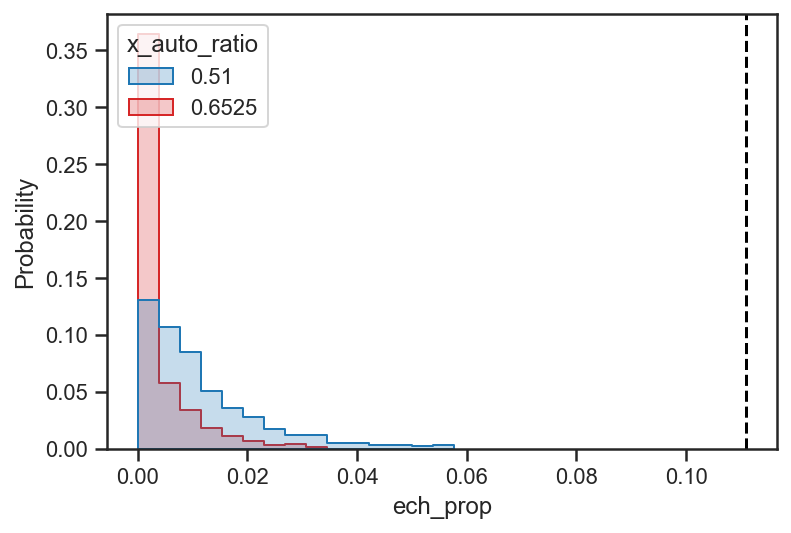

In [26]:
with sns.color_palette(['tab:blue', 'tab:red']):
    _df1['x_auto_ratio'] = _df1.x_auto_ratio.astype("category")
    sns.histplot(data=_df1, x="ech_prop", hue="x_auto_ratio", bins=15, 
                 stat='probability', element="step", fill=True)
    plt.axvline(0.111, linestyle='dashed', color='black')    

Proportion of all 100kb haplotypes called as ECH:

In [27]:
_df2 = (plot_df
 .groupby(['x_auto_ratio', 'replication'])
 .apply(lambda df: df.nr_swept.sum()/df.total.sum())
 .to_frame('ech_prop')
 .reset_index()
)
(_df2
 .groupby('x_auto_ratio')
 .agg(mean = ('ech_prop', np.mean),
     lower = ('ech_prop', percentile(0.025)),
     upper = ('ech_prop', percentile(0.975)))
)

,mean,lower,upper
x_auto_ratio,,,
0.5100,0.006861,0.0,0.024836
0.6525,0.001977,0.0,0.012139


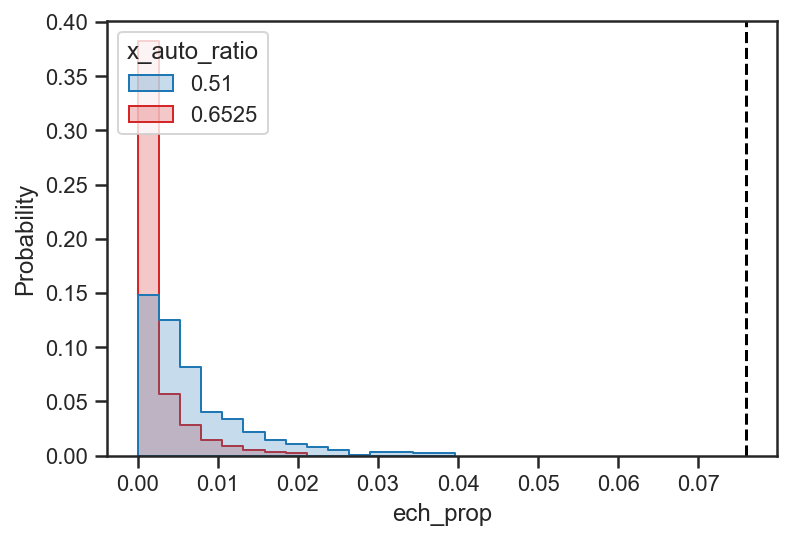

In [28]:
with sns.color_palette(['tab:blue', 'tab:red']):
    _df2['x_auto_ratio'] = _df2.x_auto_ratio.astype("category")
    sns.histplot(data=_df2, x="ech_prop", hue="x_auto_ratio", bins=15, 
                 stat='probability', element="step", fill=True)
    plt.axvline(0.076, linestyle='dashed', color='black')

In [36]:
cell_genomics = sns.plotting_context()
cell_genomics['font.size'] = 8
cell_genomics['axes.labelsize'] = 8
cell_genomics['axes.titlesize'] = 8
cell_genomics['xtick.labelsize'] = 8
cell_genomics['ytick.labelsize'] = 8
cell_genomics['legend.title_fontsize'] = 8
cell_genomics['legend.fontsize'] = 8

matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [37]:
cell_genomics

{'font.size': 8,
 'axes.labelsize': 8,
 'axes.titlesize': 8,
 'xtick.labelsize': 8,
 'ytick.labelsize': 8,
 'legend.fontsize': 8,
 'axes.linewidth': 1.25,
 'grid.linewidth': 1.0,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1.0,
 'ytick.minor.width': 1.0,
 'xtick.major.size': 6.0,
 'ytick.major.size': 6.0,
 'xtick.minor.size': 4.0,
 'ytick.minor.size': 4.0,
 'legend.title_fontsize': 8}

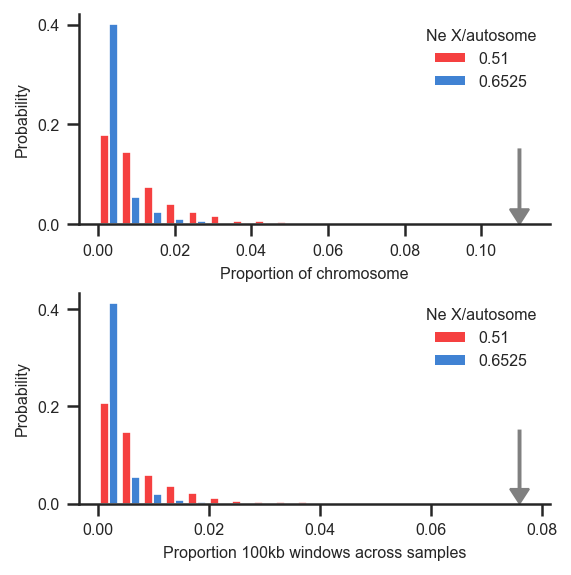

In [50]:
#with sns.color_palette(["#FF01FF", "#9300D3"]):

with sns.plotting_context(cell_genomics), sns.color_palette(['#F20000', '#0058C5']):
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 4))
    _df1['x_auto_ratio'] = _df1.x_auto_ratio.astype("category")
    sns.histplot(data=_df1, x="ech_prop", hue="x_auto_ratio", bins=10,
                 stat='probability', multiple="dodge", shrink=.8, ax=ax[0], legend=True)
    # ax[0].axvline(0.11, linestyle='dashed', color='black')  
    ax[0].set_xlabel("Proportion of chromosome")
    ax[0].arrow(0.11,0.15, 0,-0.15, length_includes_head=True, 
            head_width=0.005, width=0.0005, head_length=0.03, color='grey')
    
    _df2['x_auto_ratio'] = _df2.x_auto_ratio.astype("category")
    g = sns.histplot(data=_df2, x="ech_prop", hue="x_auto_ratio", bins=10,
                 stat='probability', multiple="dodge", shrink=.8, ax=ax[1], legend=True)
    # ax[1].axvline(0.07, linestyle='dashed', color='black')  
    ax[1].set_xlabel("Proportion 100kb windows across samples")

    ax[1].arrow(0.076,0.15, 0,-0.15, length_includes_head=True, 
                head_width=0.005 * 7.6/11.1, width=0.0005 * 7.6/11.1, head_length=0.03, color='grey')
    
    sns.move_legend(ax[0], "upper right",
                    # bbox_to_anchor=(1, 1),
                    title='Ne X/autosome', frameon=False)
    sns.move_legend(ax[1], "upper right",
                    # bbox_to_anchor=(1, 1),
                    title='Ne X/autosome', frameon=False)    

    sns.despine()
    plt.tight_layout()
    plt.savefig(ag.figures_dir / 'ceu_sims.pdf', bbox_inches='tight')
    plt.savefig(ag.figures_dir / 'ceu_sims.png', bbox_inches='tight')

Plot of ten first replications:

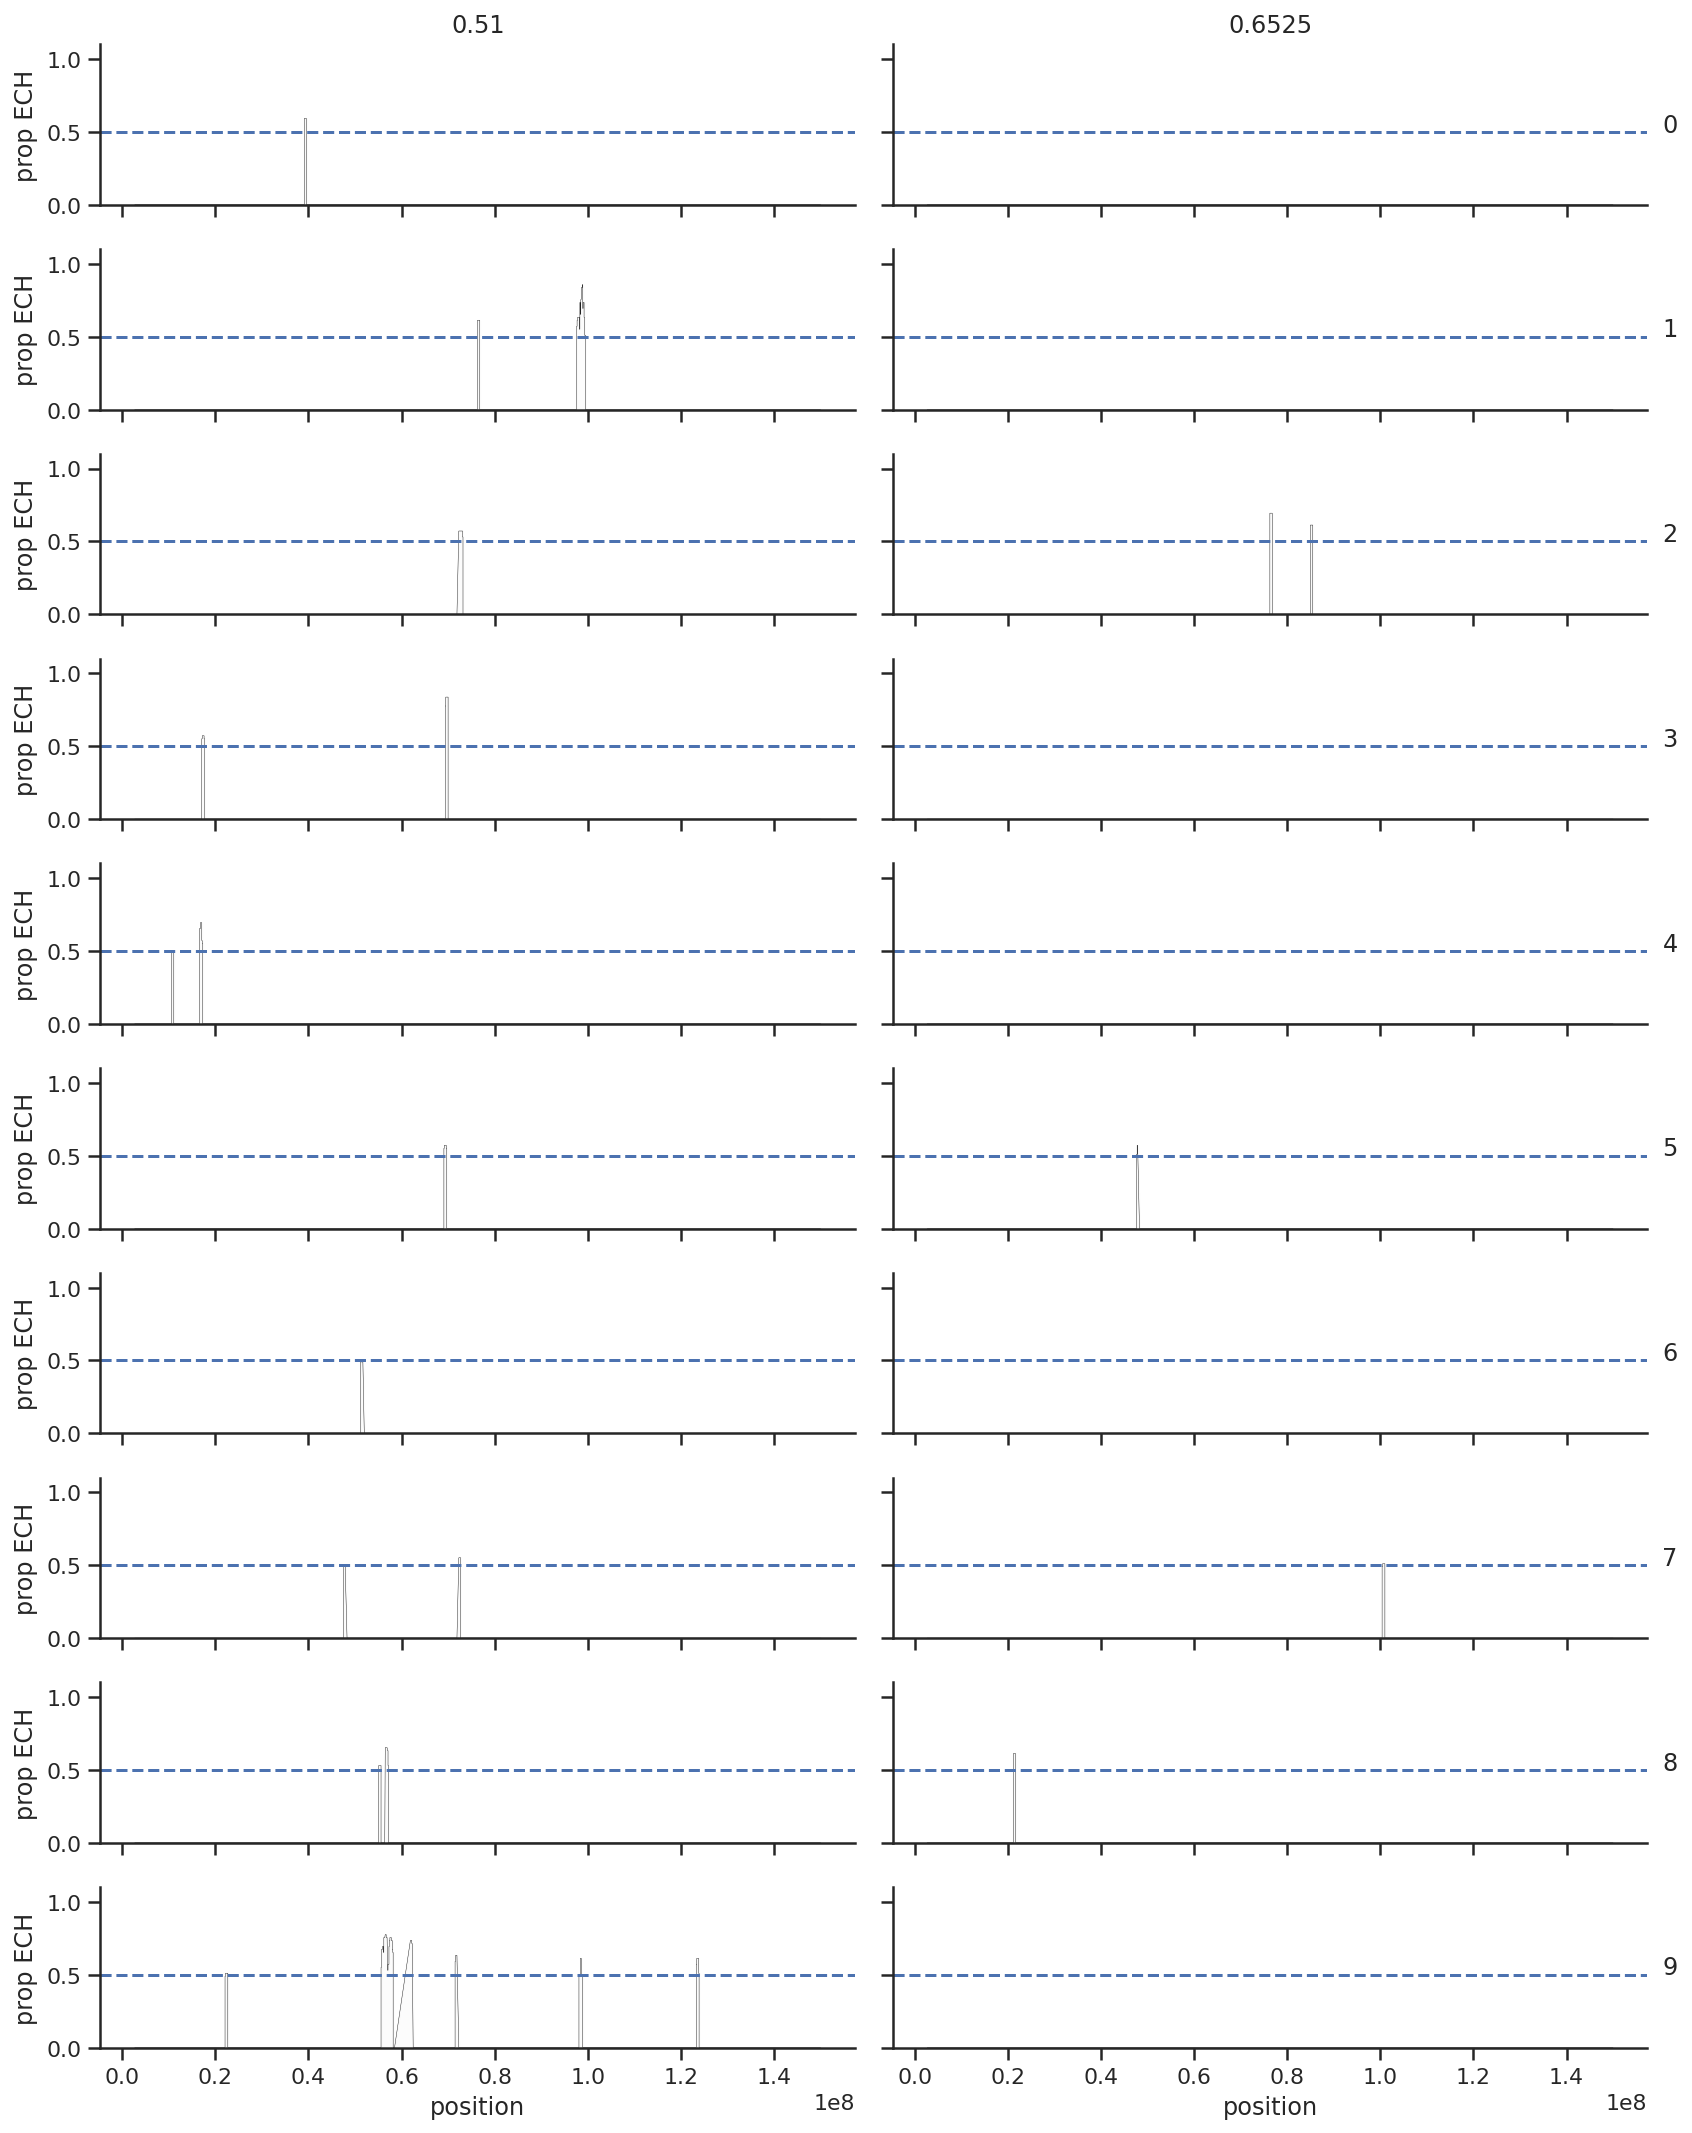

In [28]:

with sns.axes_style('ticks'):
    g = sns.FacetGrid(plot_df.loc[plot_df.replication < 10], col='x_auto_ratio', row='replication', 
                      # hue='replication',
                      sharex=True, sharey=True, margin_titles=True,
                     height=1.5, aspect=4)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

### Simulations with selection

In [29]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type != 'nosweep') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.min_clade_percent == 50) & \
                              (prop_swept_data.x_auto_ratio.isin([0.51, 0.6525]))
                             # (prop_swept_data.x_auto_ratio > 0.5)
                             ]

Proportion of chromosome windows where an ECH is called:

In [30]:
df = (plot_df
 .groupby(['x_auto_ratio', 'replication', 'sweep_type', 'selcoef'])
 .apply(lambda df: (df.nr_swept > 0).sum() / df.nr_swept.size)
 .to_frame('ech_prop')
 .reset_index()
)
(df
 .groupby(['x_auto_ratio', 'sweep_type', 'selcoef'])
 .agg(mean = ('ech_prop', np.mean),
     lower = ('ech_prop', percentile(0.025)),
     upper = ('ech_prop', percentile(0.975)),
     ceu_percentile = ('ech_prop', lambda s: (s >= 0.11).sum() / len(s))
     )
)

mean     lower     upper  ceu_percentile
x_auto_ratio sweep_type selcoef                                              
0.5100       complete   0.01     0.084132  0.073522  0.092141             0.0
                        0.10     0.218713  0.171501  0.255632             1.0
             episode    0.01     0.011003  0.000000  0.028743             0.0
                        0.02     0.015494  0.000000  0.045715             0.0
             partial    0.01     0.086153  0.074457  0.094629             0.0
                        0.10     0.219237  0.182915  0.263641             1.0
0.6525       complete   0.01     0.072081  0.052676  0.086078             0.0
                        0.10     0.200823  0.183552  0.217290             1.0
             episode    0.01     0.008757  0.000000  0.029098             0.0
                        0.02     0.004491  0.000000  0.030689             0.0
             partial    0.01     0.076497  0.059076  0.095696             0.0
                        0.10     0.191617  0.166860  0.211321             1.0

Proportion of all 100kb haplotypes called as ECH:

In [31]:
df = (plot_df
 .groupby(['x_auto_ratio', 'replication', 'sweep_type', 'selcoef'])
 .apply(lambda df: df.nr_swept.sum()/df.total.sum())
 .to_frame('ech_prop')
 .reset_index()
)
(df
 .groupby(['x_auto_ratio', 'sweep_type', 'selcoef'])
 .agg(mean = ('ech_prop', np.mean),
     lower = ('ech_prop', percentile(0.025)),
     upper = ('ech_prop', percentile(0.975)))
)

mean     lower     upper
x_auto_ratio sweep_type selcoef                              
0.5100       complete   0.01     0.070503  0.060541  0.076102
                        0.10     0.188915  0.154339  0.223371
             episode    0.01     0.007129  0.000000  0.021054
                        0.02     0.009833  0.000000  0.028807
             partial    0.01     0.071584  0.062629  0.076497
                        0.10     0.187792  0.156958  0.223656
0.6525       complete   0.01     0.062763  0.048378  0.072483
                        0.10     0.171937  0.151106  0.184902
             episode    0.01     0.005404  0.000000  0.019000
                        0.02     0.002640  0.000000  0.017869
             partial    0.01     0.064168  0.053475  0.076405
                        0.10     0.165211  0.140076  0.188512

## ECH peaks for X constant recombination rate


Load neutral ECH summary for X:

In [46]:
prop_swept_data = (pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf'))
                      .loc[lambda df: (df.chrom == 'X') & (df.rec_mode == 'constrate')]
                  )
prop_swept_data['min_clade_percent'] = prop_swept_data['min_clade_percent'].astype(int)

prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total
prop_swept_data['x_auto_ratio'] = prop_swept_data['size_reduction'] * 3 / 4
prop_swept_data.head()

,start,end,nr_swept,total,demography,chrom,size_reduction,rec_rate_per_gen,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept,x_auto_ratio
0,0,100000,0,140,standard,X,0.87,1.160000e-08,0,nosweep,0.0,14,50,0.0,0.6525
1,100000,200000,0,140,standard,X,0.87,1.160000e-08,0,nosweep,0.0,14,50,0.0,0.6525
2,200000,300000,0,140,standard,X,0.87,1.160000e-08,0,nosweep,0.0,14,50,0.0,0.6525
3,300000,400000,0,140,standard,X,0.87,1.160000e-08,0,nosweep,0.0,14,50,0.0,0.6525
4,400000,500000,0,140,standard,X,0.87,1.160000e-08,0,nosweep,0.0,14,50,0.0,0.6525


## Neutral simulations

Standard demography:

This many replications times 10Mb:

In [41]:
prop_swept_data.replication.unique().size

15

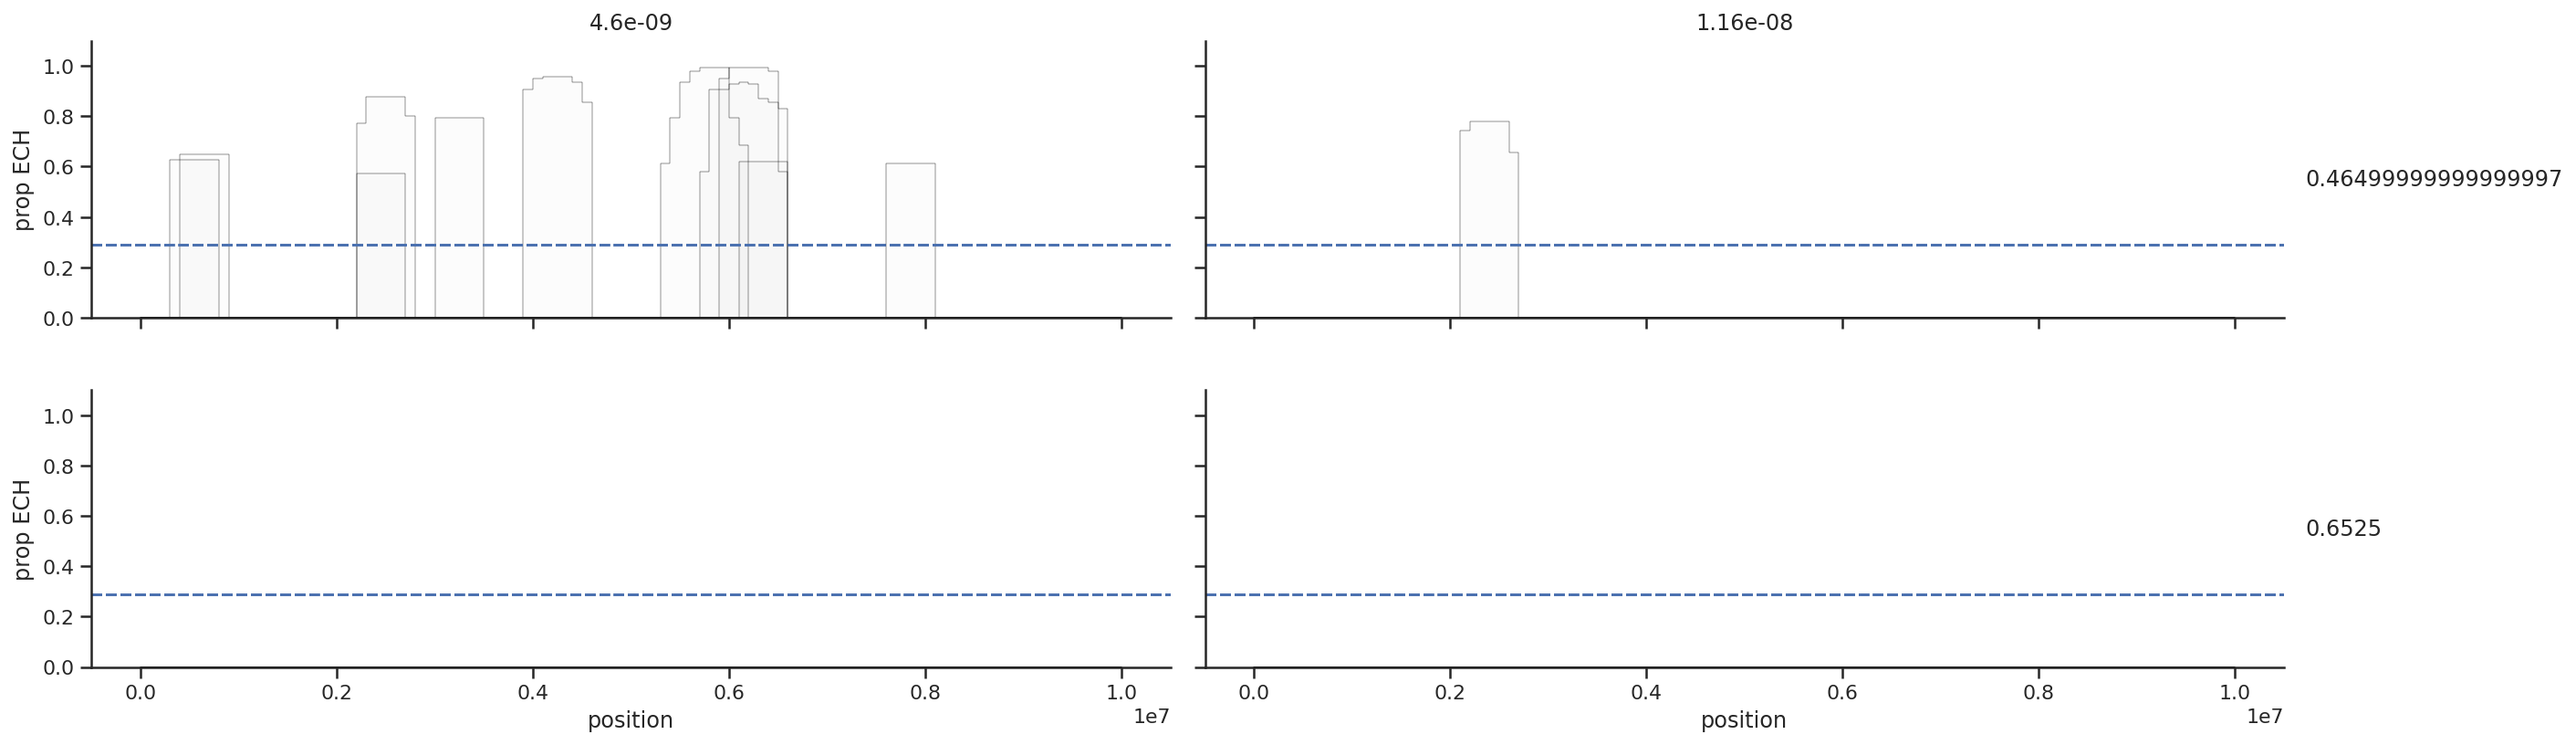

In [42]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.min_clade_percent == '50')]

with sns.axes_style('ticks'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=3, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

When we compute the probability of obtaining an ECH in the most conservative scenario, we need to take into account that this only applies to a small part of the X.

Truncated demography:

In [43]:
# plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
#                               (prop_swept_data.demography == 'truncated')]

# with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
#                       hue='replication', sharex=True, sharey=True, margin_titles=True,
#                      height=2, aspect=3)
#     g.map(facet_plot, 'start', 'end', 'prop_swept')

#     for ax in g.axes.flat:
#         plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
#     g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

#     for ax in g.axes.flat:
#         ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
#         ax.set_ylabel('prop ECH')        
#         plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

In [44]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.rec_rate_per_gen == 4.6e-9) & \
                              (prop_swept_data.x_auto_ratio == 0.48)] 

with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='replication', col_wrap=15,
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                      height=2, aspect=1)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") 

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2160x0 with 0 Axes>

In [17]:
# plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
#                               (prop_swept_data.demography == 'truncated') & \
#                               (prop_swept_data.rec_rate_per_gen == 4.6e-9) & \
#                               (prop_swept_data.x_auto_ratio == 0.48)] 

# with sns.axes_style('white'):
#     g = sns.FacetGrid(plot_df, col='replication', col_wrap=15,
#                       hue='replication', sharex=True, sharey=True, margin_titles=True,
#                      height=2, aspect=1)
#     g.map(facet_plot, 'start', 'end', 'prop_swept')

#     for ax in g.axes.flat:
#         plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
#     g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

#     for ax in g.axes.flat:
#         ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
#         ax.set_ylabel('prop ECH')        
#         plt.setp(ax.texts, rotation="0") 

Load 90% ECH regions

In [18]:
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
extended_peak_regions_90['chrom'] = 'chrX'

### Plots to make for real data and simulations

- Proportion of ECH in each individual
- Number of peaks that each individual is part of (accounting for whole chrX vs. 10Mb)
- Length distribution of ECHs
- Proportion of individuals with ECH (where ECHs ca called)

### Distribution of ECH peak heights and proportion of ECH across simulations

In [19]:
subset_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard')]

Proportion of ECH across simulations:

In [20]:
subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.018060
                  0.66            0.001267
1.160000e-08      0.48            0.000000
                  0.66            0.000000
Name: prop_swept, dtype: float64

Bootstrap batches of 15 simulations to reproduce ~150Mb X chromosome to get 95% percentile:

In [21]:
def bootstrap(df):
    return pd.Series([df.iloc[np.random.randint(len(df), size=15)].prop_swept.mean() for _ in range(10000)])

df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).apply(bootstrap).reset_index()
df = df.melt(id_vars=['rec_rate_per_gen', 'x_auto_ratio'])

In [22]:
from scipy import stats


In [23]:
df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).value.agg(mean_prop_swept=np.mean, 
                                                           quantile_5=lambda sr: np.quantile(sr, q=0.05),
                                                           quantile_95=lambda sr: np.quantile(sr, q=0.95),
                                                           prob=lambda sr: 1-stats.percentileofscore(sr, 0.14)/100
                                                          )

mean_prop_swept  quantile_5  quantile_95  \
rec_rate_per_gen x_auto_ratio                                             
4.600000e-09     0.48                 0.018289         0.0     0.068095   
                 0.66                 0.001261         0.0     0.000000   
1.160000e-08     0.48                 0.000000         0.0     0.000000   
                 0.66                 0.000000         0.0     0.000000   

                                 prob  
rec_rate_per_gen x_auto_ratio          
4.600000e-09     0.48          0.0008  
                 0.66          0.0000  
1.160000e-08     0.48          0.0000  
                 0.66          0.0000

This is what compared to the 14% ECH in the actual data.

Distribution of peak prop_swept in simulations compared to our observations:

In [24]:
plot_df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio', 'replication']).prop_swept.max().reset_index().loc[lambda df: df.prop_swept > 0]
plot_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.550510
                  0.66            0.489286
Name: prop_swept, dtype: float64

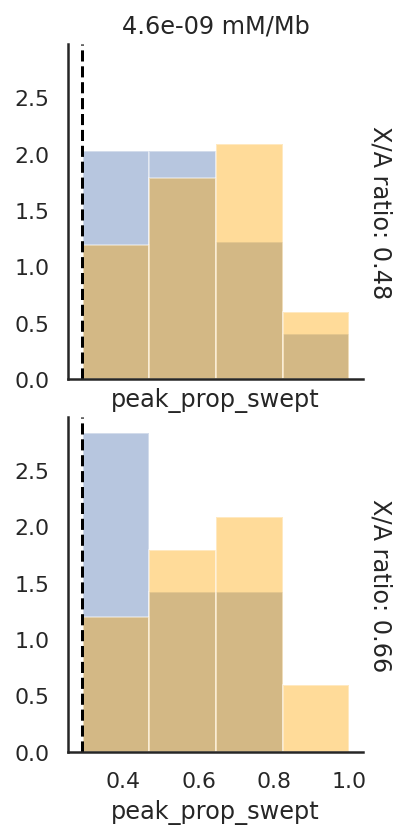

In [25]:
with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio',
                      sharex=True, sharey=True, margin_titles=True, legend_out=True,
                     # height=2, aspect=1
                     )
    bins = np.linspace(plot_df.prop_swept.min(), 1, 5)
#     bins = None
    norm_hist = True
    kde = False
    g.map(sns.distplot, 'prop_swept', kde=kde, norm_hist=norm_hist, bins=bins)
    
    for ax in g.axes.flat:
        sns.distplot(extended_peak_regions_90.peak_prop_swept, ax=ax, color='orange', kde=kde, norm_hist=norm_hist, bins=bins)
        ax.axvline(0.29, linestyle='dashed', color='black')
    
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = 'X/A ratio: {row_name}', col_template = '{col_name} mM/Mb')

In [26]:
subset_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'truncated')]

Proportion of ECH across simulations:

In [27]:
subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.055467
                  0.66            0.005682
1.160000e-08      0.48            0.004986
                  0.66            0.000154
Name: prop_swept, dtype: float64

This is what compared to the 14% ECH in the actual data. Given that only a part of the chromosme is as extreme as our regions, the expected prop_swept is between 1% and 5%:

Distribution of peak prop_swept in simulations compared to our observations:

In [28]:
plot_df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio', 'replication']).prop_swept.max().reset_index().loc[lambda df: df.prop_swept > 0]
plot_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.458992
                  0.66            0.369048
1.160000e-08      0.48            0.374436
                  0.66            0.307143
Name: prop_swept, dtype: float64

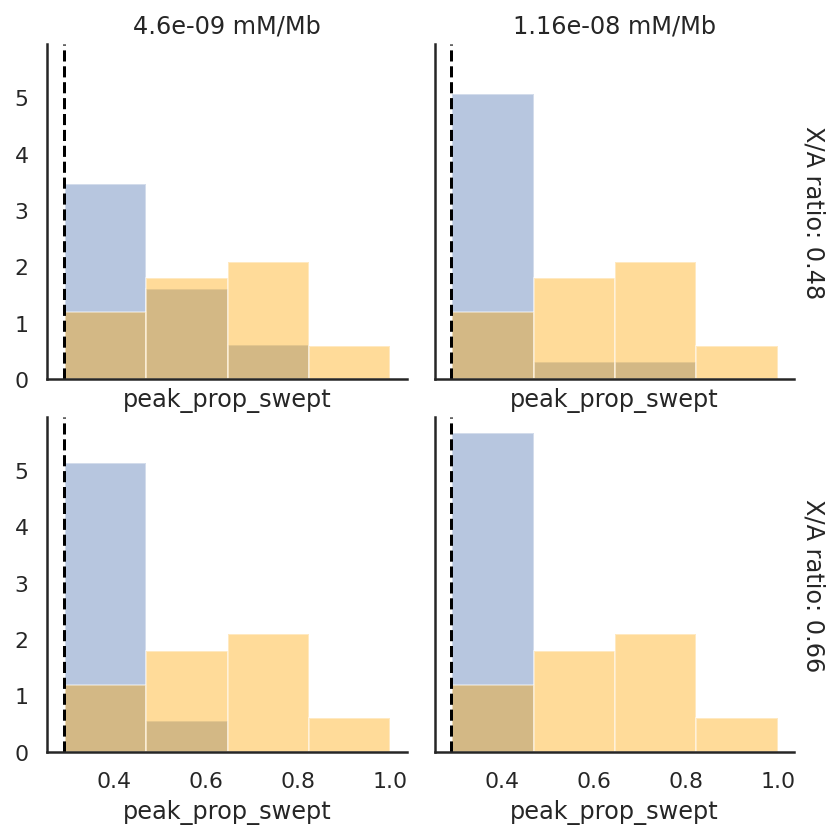

In [29]:
with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio',
                      sharex=True, sharey=True, margin_titles=True,
                     # height=2, aspect=1
                     )
    bins = np.linspace(plot_df.prop_swept.min(), 1, 5)
#     bins = None
    norm_hist = True
    kde = False
    g.map(sns.distplot, 'prop_swept', kde=kde, norm_hist=norm_hist, bins=bins)
    
    for ax in g.axes.flat:
        sns.distplot(extended_peak_regions_90.peak_prop_swept, ax=ax, color='orange', kde=kde, norm_hist=norm_hist, bins=bins)
        ax.axvline(0.29, linestyle='dashed', color='black')
    
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = 'X/A ratio: {row_name}', col_template = '{col_name} mM/Mb')

## Complete sweeps

s = 0.1

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

s = 0.01

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.01) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

## Partial sweeps

s = 0.1

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'partial') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

s = 0.01

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'partial') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.01) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

-----

In [ ]:
with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.str.startswith('standard_40_4650')],
                      col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=3, aspect=5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [ ]:
prop_swept_data.simulation.unique()

In [ ]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.5)

with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.isin(['standard_55_4650_X_nosweep_98275',
                                                                          'standard_40_4650_X_nosweep_98275',
                                                                          'standard_48_4650_X_nosweep_98275',
                                                                          'standard_66_4650_X_nosweep_98275'])],
                      col='replication', row='simulation', sharex=True, sharey=True, margin_titles=True,
                     height=4, aspect=0.5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



#  Old code for comparing autosomal SFS and LD simulations to simons data

## Mean pairwise differences

In [9]:
! ls ../steps/slim/simulations/standard/100/

constrec


In [10]:
dir_path = ag.root_dir / 'steps/slim/simulations/standard/100/constrec/11300/A/nosweep/0/0/'
means = list()
for path in dir_path.iterdir():
#     if path.name.endswith('0_0_0.hdf'):
    if re.search(r'\d+.hdf$', path.name):
        df = pd.read_hdf(path)
        means.append(df.dist.mean())
np.mean(means)

0.0007371296258503402

This should match autosome pi of observed data computed in previous notebook

## SFS

Compute SFS for chromosome 7:

In [29]:
freq_data_obs = pd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_individuals_chr7_with_aa.frq', sep='\t',
                        skiprows=1, names=['chrom','pos', 'n_alleles', 'n_chr', 'anc_freq', 'der_freq'])
freq_data_obs.head()
# histogram of frequencies with specified bins

,chrom,pos,n_alleles,n_chr,anc_freq,der_freq
0,7,118084,2,280,0.778571,0.221429
1,7,118114,2,280,0.307143,0.692857
2,7,118184,2,280,0.996429,0.003571
3,7,118232,2,280,0.732143,0.267857
4,7,118268,2,280,0.989286,0.010714


In [20]:
freq_data_obs.der_freq.min(), freq_data_obs.der_freq.max() # strange...
# maybe it is because I did not recode or soemthing to remove monomorphic sites after subsetting the VCF...

(0.0, 1.0)

Compute SFS for simulations:

In [21]:
# use pathlib to glob all freq files
path = Path(ag.root_dir / 'steps/slim/simulations/standard/100/11300/A/nosweep')
df_list = []
for path in path.glob('**/standard*A_nosweep*.frq'):
    df = pd.read_csv(path, sep='\t', header=0, names=['chrom', 'pos', 'n_alleles', 'n_chr', 'anc_freq', 'der_freq'])
    df_list.append(df)

freq_data_sim = pd.concat(df_list)
freq_data_sim.head()

In [23]:
freq_data_sim.der_freq.min(), freq_data_sim.der_freq.max() # strange...

# for each file: read it in, concat result to list of dfs
# concat all dfs

# histogram of frequencies with specified bins

(0.00714286, 1.0)

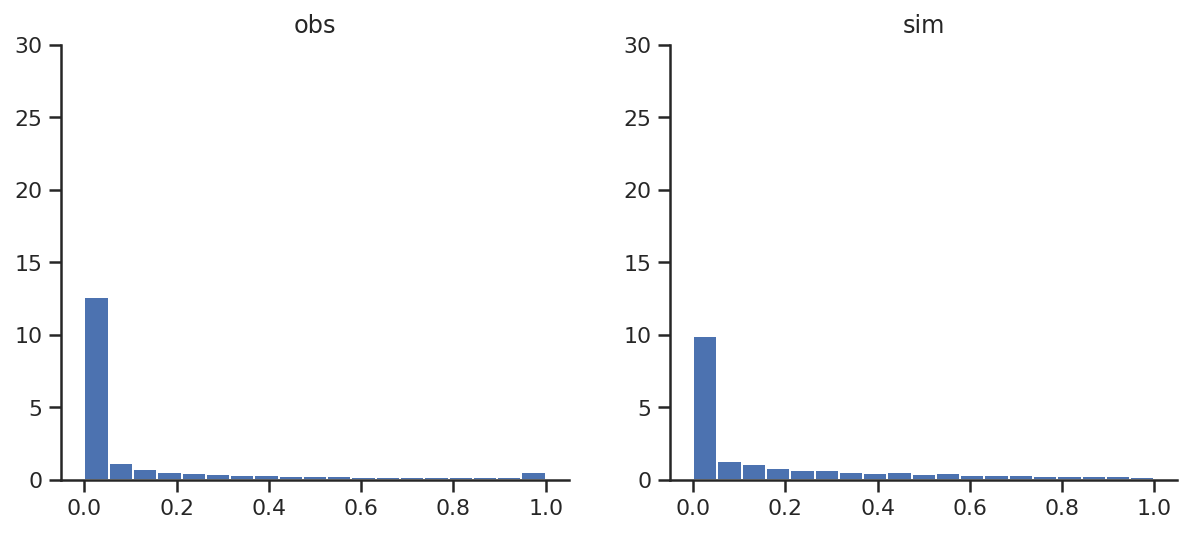

In [26]:
nbins = 20
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(freq_data_obs.loc[(freq_data_obs.der_freq > 0) & (freq_data_obs.der_freq < 1)].der_freq, 
         bins=np.linspace(0, 1, nbins), density=True)
axes[0].set_title('obs')
axes[1].hist(freq_data_sim.loc[(freq_data_sim.der_freq > 0) & (freq_data_sim.der_freq < 1)].der_freq, 
         bins=np.linspace(0, 1, nbins), density=True)
axes[1].set_title('sim')
axes[0].set_ylim(top=30)
axes[1].set_ylim(top=30)
sns.despine()

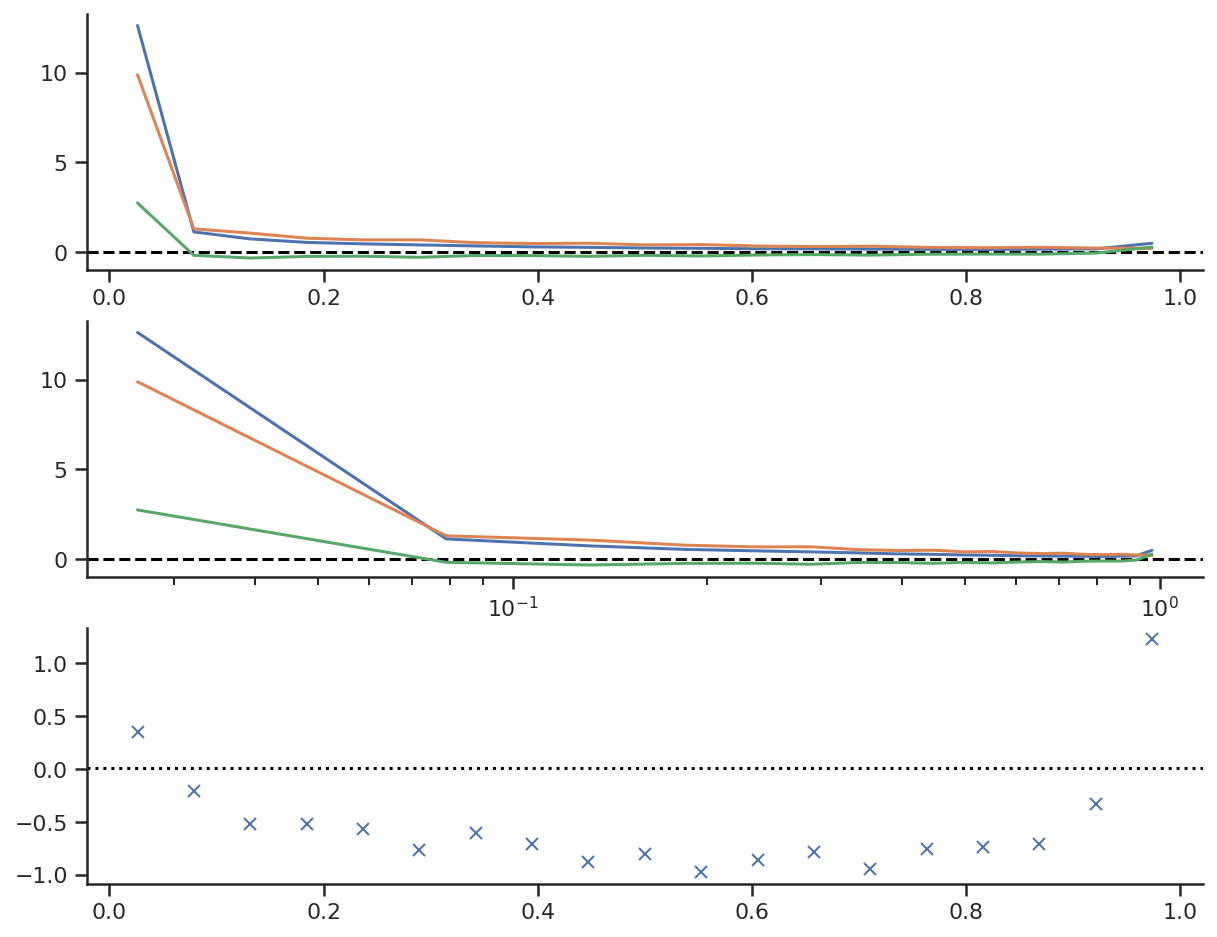

In [27]:
freq_data_sim_hist = np.histogram(freq_data_sim.loc[(freq_data_sim.der_freq > 0) & (freq_data_sim.der_freq < 1)].der_freq,
             bins=np.linspace(0, 1, nbins), density=True)
freq_data_obs_hist = np.histogram(freq_data_obs.loc[(freq_data_obs.der_freq > 0) & (freq_data_obs.der_freq < 1)].der_freq, 
             bins=np.linspace(0, 1, nbins), density=True)

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
x = freq_data_obs_hist[1][:-1] + (freq_data_obs_hist[1][1:] - freq_data_obs_hist[1][:-1])/2

axes[0].axhline(0, color='black', linestyle='dashed')
axes[0].plot(x, freq_data_obs_hist[0])
axes[0].plot(x, freq_data_sim_hist[0])
axes[0].plot(x, freq_data_obs_hist[0] - freq_data_sim_hist[0])

axes[1].axhline(0, color='black', linestyle='dashed')
axes[1].plot(x, freq_data_obs_hist[0])
axes[1].plot(x, freq_data_sim_hist[0])
axes[1].plot(x, freq_data_obs_hist[0] - freq_data_sim_hist[0])
axes[1].set_xscale('log')

axes[2].plot(x, np.log2(freq_data_obs_hist[0] / freq_data_sim_hist[0]), 'x')
axes[2].axhline(0.01, color='black', linestyle='dotted')

sns.despine()

## LD decay

Compute LD decay for chromosome 7:

In [16]:
import dask.dataframe as dd

In [10]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=True, memory_limit='16GB')
client

Client Scheduler: tcp://127.0.0.1:43172 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 16.00 GB


In [48]:
# ssh -L8787:s05n16.genomedk.net:8787 kmt@login.genome.au.dk

In [49]:
#client.shutdown()
# client.close()
# client.restart()

In [50]:
ld_data_obs = dd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_individuals_chr7_with_aa.geno.ld',
                 sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])

ld_data_obs['dist'] = (ld_data_obs.pos1 - ld_data_obs.pos2).abs().round(-3)

In [51]:
ld_data_obs_means = ld_data_obs.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')
ld_data_obs_means.head()

,dist,r2
0,0,0.263952
1,1000,0.252805
2,2000,0.241179
3,3000,0.230312
4,4000,0.220760


In [24]:
ld_data_obs_eur = dd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_europeans_chr7_with_aa.geno.ld',
                 sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])

ld_data_obs_eur['dist'] = (ld_data_obs_eur.pos1 - ld_data_obs_eur.pos2).abs().round(-3)

ld_data_obs_eur_means = ld_data_obs_eur.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')
ld_data_obs_eur_means.head()

,dist,r2
0,0,0.329777
1,1000,0.327516
2,2000,0.313698
3,3000,0.301369
4,4000,0.290355


In [25]:
ld_data_obs_papuans = dd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_papuans_chr7_with_aa.geno.ld',
                 sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])

ld_data_obs_papuans['dist'] = (ld_data_obs_papuans.pos1 - ld_data_obs_papuans.pos2).abs().round(-3)

ld_data_obs_papuans_means = ld_data_obs_papuans.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')
ld_data_obs_papuans_means.head()

,dist,r2
0,0,0.419400
1,1000,0.433335
2,2000,0.421635
3,3000,0.409062
4,4000,0.397075


In [26]:
#client.shutdown()

Compute LD decay for simulations:

In [15]:
glob = str(ag.root_dir) + \
    '/steps/slim/simulations/standard/100/11300/A/nosweep/*/*/standard_100_11300_A_nosweep*.hap.ld'
ld_data_sim = dd.read_csv(glob, sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_chrom', 'r2', 'D', 'Dprime'])
ld_data_sim['dist'] = (ld_data_sim.pos1 - ld_data_sim.pos2).abs().round(-3)
ld_data_sim.head()

,chrom,pos1,pos2,n_chrom,r2,D,Dprime,dist
0,1,26,6328,140,0.011191,0.006224,1.0,6000
1,1,26,6606,140,0.011858,0.006429,1.0,7000
2,1,26,8910,140,0.011191,0.006224,1.0,9000
3,1,26,9419,140,0.011191,0.006224,1.0,9000
4,1,26,11034,140,0.154589,0.013061,1.0,11000


In [27]:
ld_data_sim_means = ld_data_sim.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')

In [28]:
ld_data_sim_means.head()

,dist,r2
0,0,0.368283
1,1000,0.291747
2,2000,0.235641
3,3000,0.201981
4,4000,0.178394


In [16]:
glob = str(ag.root_dir) + \
    '/steps/slim/simulations/standard/100/11300/A/nosweep/*/*/standard_100_11300_A_nosweep*.geno.ld'
ld_geno_data_sim = dd.read_csv(glob, sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])
ld_geno_data_sim['dist'] = (ld_geno_data_sim.pos1 - ld_geno_data_sim.pos2).abs().round(-3)

ld_geno_data_sim_means = ld_geno_data_sim.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')

In [17]:
ld_geno_data_sim_means.head()

,dist,r2
0,0,0.310287
1,1000,0.246588
2,2000,0.199653
3,3000,0.173232
4,4000,0.153783


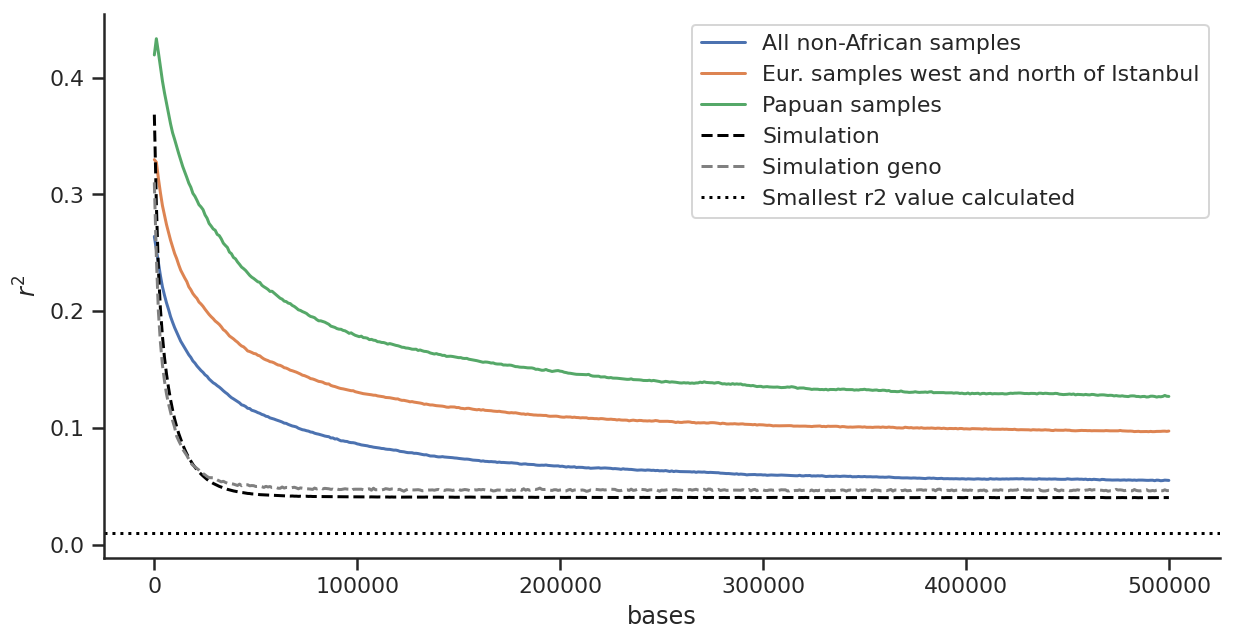

In [21]:
plt.figure(figsize=(10,5))
plt.plot(ld_data_obs_means.dist, ld_data_obs_means.r2, '-', label='All non-African samples')
plt.plot(ld_data_obs_eur_means.dist, ld_data_obs_eur_means.r2, '-', label='Eur. samples west and north of Istanbul')
plt.plot(ld_data_obs_papuans_means.dist, ld_data_obs_papuans_means.r2, '-', label='Papuan samples')
plt.plot(ld_data_sim_means.dist, ld_data_sim_means.r2, '--',color='black', label='Simulation')
plt.plot(ld_geno_data_sim_means.dist, ld_geno_data_sim_means.r2, '--',color='grey', label='Simulation geno')
plt.ylabel('$r^2$')
plt.xlabel('bases')
#plt.xscale('log')
plt.axhline(0.01, color='black', linestyle='dotted', label='Smallest r2 value calculated')
#plt.xlim(0, 10000)
plt.legend()
sns.despine()

### What to do?

The lower LD propably results from simulated panmixia rather than non-African population structure.

In the observed data, structure will tend to maintain LD within populations that is then only disrupted when we come close to the bottleneck.

1. Read [Gutenkunst paper](https://academic.oup.com/g3journal/article/7/11/3605/6027516) about inference
2. Make an experiment where you know what the LD decay: Try to simulate a few with Terhorst 1000 genomes CEU deomography and compute LD again.
3. 




Maybe use the Terhorst CEU but with out rescaling to fit pi
Then simulate with slim
Then raise mutation rate in slim to fit observed pi

In [31]:
ld_data_obs_means.to_hdf(ag.results_dir / 'ld_data_obs_means.hdf', 'df', format='table', mode='w')
ld_data_obs_eur_means.to_hdf(ag.results_dir / 'ld_data_obs_eur_means.hdf', 'df', format='table', mode='w')
ld_data_obs_papuans_means.to_hdf(ag.results_dir / 'ld_data_obs_papuans_means.hdf', 'df', format='table', mode='w')
ld_data_sim_means.to_hdf(ag.results_dir / 'ld_data_sim_means.hdf', 'df', format='table', mode='w')
ld_data_geno_sim_means.to_hdf(ag.results_dir / 'ld_data_geno_sim_means.hdf', 'df', format='table', mode='w')

NameError: name 'ld_data_obs_means' is not defined

In [18]:
# ld_data_obs_means = pd.read_hdf(ag.results_dir / 'ld_data_obs_means.hdf')
# ld_data_obs_eur_means = pd.read_hdf(ag.results_dir / 'ld_data_obs_eur_means.hdf')
# ld_data_obs_papuans_means = pd.read_hdf(ag.results_dir / 'ld_data_obs_papuans_means.hdf')
# ld_data_sim_means = pd.read_hdf(ag.results_dir / 'ld_data_sim_means.hdf')

In [ ]:
# use pathlib to glob all LD files
# for each file: read it in, round pos to even 1000, groupby rounded distances and compute mean r2 for each group, concat result to list of dfs
# concat all dfs
# plot decay

path = Path(ag.root_dir / 'steps/slim/simulations/standard/100/11300/A/nosweep')
df_list = []
for path in path.glob('**/standard*A_nosweep*.hap.ld'):
    df = pd.read_csv(path, sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])
    df_list.append(df)

freq_data_sim = pd.concat(df_list)

ld_data_sim['dist'] = (ld_data_sim.pos1 - ld_data_sim.pos2).abs().round(-3)
ld_data_sim.head()

In [ ]:
ld_data_sim_means = ld_data_sim.groupby('dist').r2.mean().reset_index().sort_values(by='dist')

In [ ]:
plot_df = ld_data_sim_means.reset_index()
plt.plot(plot_df.dist, plot_df.r2, '-')
plt.xscale('log')

## TMRCA computations

In [ ]:
# from math import exp

# def lamb(i):
#     # lamb(i) rate of coalescence from i-1 to i
#     i += 1
#     return i*(i-1)/2

# samples = 5 # total samples
# setsize = 3 # size of clade (we want to see at least one such clade coalesce before time t)
# t = 1

# for n in range(setsize, samples+1):
#     # loop from setsize to samples (3 to 5):
#     p = 0
#     for i in range(1, n):
#         # loop from 1 to n-1:
#         p += np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j]) \
#         * exp(-lamb(n)*t) \
#         * (lamb(i)/(lamb(i)-lamb(n))) \
#         * (-exp(-(lamb(i)-lamb(n))*t) + 1)
#     # combinatorial expression:
#     p *= scipy.misc.comb(n, setsize) / scipy.misc.comb(samples, setsize)
# p
    


In [ ]:
# def lamb(x):
#     x += 1
#     return x*(x-1)/2


# N = 3000
# n = 42
# t = 1

# prob = 0
# for i in range(1, n):
#     prob += (1 - math.exp(-lamb(i)*t)) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j])
# prob * scipy.misc.comb(140, 42)

In [ ]:
#scipy.misc.comb(140, 42)

In [ ]:
#1- math.exp(-lamb(1))

In [ ]:
# def lamb(x):
#     return x*(x-1)/2

# t = 10
# n = 20

# prob = 0
# for i in range(1, n+1):
# #     print([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
#     prob += lamb(i) * math.exp(-lamb(i)*t) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
# prob #* scipy.misc.comb(n, i)

In [ ]:
#lamb(3)

In [ ]:
# import scipy

# def coal_n_to_l(n, l, t):
#     """Prob of reducing n lineages to l in time t"""
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     return scipy.linalg.expm(Q*t)[0][-1]

# def clade_prob(n, l, t, i):
#     """Prob of one among l lineages being ancestor to i among n"""
# #     if i == 1 or l == 1:
# #         return 1
# #     else:
#     return scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)
        
# n = 5
# t = 36
# pop_size = 300
# i = 2

# total_prop = 0
# for l in range(1, n):
#     total_prop += coal_n_to_l(n, l, t) * clade_prob(n, l, t, i)
# total_prop

In [ ]:
# n = 5
# t = 360
# pop_size = 30

# i = 2

# #l = 3

# total_prop = 0

# for l in [3]:#range(1, n):
    
#     # probability of having l out of n left at time t
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     prop_coalescences_n_to_l = scipy.linalg.expm(Q*t)[0][-1]
#     prop_coalescences_n_to_l

    
#     if i == 1 or l == 1:
#         prop_ancestor_to_i = 1 # CHECK THAT THIS IS OK
#     else:
#         prop_ancestor_to_i = scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)

#     assert prop_ancestor_to_i <= 1, prop_ancestor_to_i

#     prob = prop_coalescences_n_to_l * prop_ancestor_to_i

#     print(prop_coalescences_n_to_l, prop_ancestor_to_i)

#     total_prop += prob
# total_prop